<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Introduction

In this notebook, I'm designing an __algorithm that can visually diagnose melanoma, the deadliest form of skin cancer__. In particular, the algorithm will try to distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).  

I also share what I learned from my mistakes!

![title](https://github.com/sebastienlange/dermatologist-ai/blob/master/images/skin_disease_classes.png?raw=1)

# Install Prerequisites

In [1]:
# google colab does not come with torch installed.
!pip install -q torch==1.0.0 torchvision

# display live plots while training (loss, accuracy, ROC AUC...)
!pip install -q livelossplot

# may need to restart environment
!pip install -q --no-cache-dir -I pillow

    100% |████████████████████████████████| 591.8MB 26kB/s 
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
    100% |████████████████████████████████| 2.0MB 32.9MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


# Download Data

In [0]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import io

from tqdm import tqdm_notebook as tqdm
from pathlib import Path

phases = ['train', 'valid', 'test']
data_root = os.path.join(os.getcwd(), 'data')
data_dir = {phase:os.path.join(data_root, phase) for phase in phases}

In [3]:
# download train.zip, valid.zip, test.zip
for phase in phases:
  url = f'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/{phase}.zip'
  !wget -nc $url -P $data_root

--2019-03-07 17:14:59--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.236.41
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.236.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5736557430 (5.3G) [application/zip]
Saving to: ‘/content/data/train.zip’

train.zip           100%[===================>]   5.34G  21.3MB/s    in 4m 23s  

2019-03-07 17:19:23 (20.8 MB/s) - ‘/content/data/train.zip’ saved [5736557430/5736557430]

--2019-03-07 17:19:24--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.236.33
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.236.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 864538487 (824M) [application/zip]
Saving to: ‘/content/data/v

In [4]:
# unzip train.zip, valid.zip, test.zip
for phase in phases:
  if not Path(data_dir[phase]).exists():
    with zipfile.ZipFile(os.path.join(data_root, f'{phase}.zip'), 'r') as myzip:
      for file in tqdm(myzip.namelist(), desc=f'Extracting {phase}.zip'):
        myzip.extract(member=file, path=data_root)

# Explore Data

In [2]:
classes = [path.split(os.path.sep)[-1] for path in sorted(glob.glob(os.path.join(data_root, 'train', '*')))]
classes

['melanoma', 'nevus', 'seborrheic_keratosis']

These are our 3 classes! Let's now explore how much data we have and how it's distributed:

In [0]:
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

def print_images_distribution(plot=False):

  image_repartition = pd.DataFrame(index=[d.split(os.path.sep)[-1] for d in data_dir.values()], columns=classes)
  plot_data = pd.DataFrame(columns=['Class', 'Phase', 'Count'])
  
  for phase in [d.split(os.path.sep)[-1] for d in data_dir.values()]:
    for disease in classes:
      count =  len(glob.glob(os.path.join(data_root, phase, disease, '*.jpg')))
      image_repartition.loc[phase][disease] = count
      plot_data = plot_data.append({'Class': disease, 'Phase': phase, 'Count': count}, ignore_index=True)

  image_repartition.loc['TOTAL'] = image_repartition.sum(axis=0)          
  image_repartition['TOTAL'] = image_repartition.sum(axis=1)
  image_repartition['Ratio'] = np.round(image_repartition.TOTAL / (image_repartition.TOTAL.sum() - image_repartition.TOTAL[-1]), 2)
  
  if plot:
    sns.set_style("whitegrid")
    sns.barplot(x='Class', y='Count', hue='Phase', data=plot_data, palette='Blues')

  return image_repartition

melanoma nevus seborrheic_keratosis   TOTAL  Ratio
train      374  1372                  254  2000.0   0.73
valid       30    78                   42   150.0   0.05
test       117   393                   90   600.0   0.22
TOTAL      521  1843                  386  2750.0   1.00

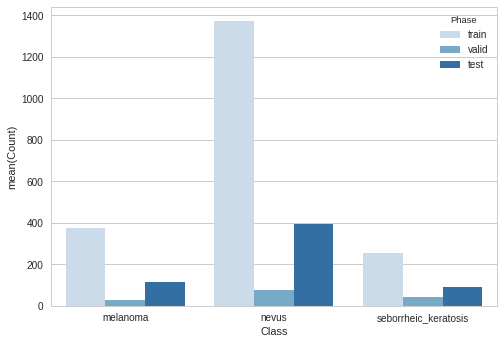

In [4]:
print_images_distribution(True)

## Class imbalance
We have a __class imbalance problem__ in this dataset: __nevus is much more represented__ whereas we are interested to have a great accuracy in the prediction of melanoma and seborrheic_keratosis.  

Without any change, the model would just learn to predict nevus. (My first mistake 😉)

## Download more data

Fortunately, we can __download more samples__ from [ISIC Archive](https://www.isic-archive.com/#!/onlyHeaderTop/gallery).  

So let's download more samples and ensure we don't have any duplicate!


In [0]:
data_dir['more'] = os.path.join(data_root, 'more')

The additional data is stored on my own Google Drive.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def get_unique_images(myzip):
  # prevent having any duplicate accross train, valid and test!!!
  
  for image_file in myzip.namelist():
    duplicate = False
    for d in data_dir.values():
      if Path(f'{d}/{disease}/{image_file}').exists():
        duplicate = True
    if not duplicate:
      yield image_file

In [8]:
for disease in classes:
  for fn in sorted(glob.glob(f'/content/gdrive/My Drive/{disease}*.zip')):
    with zipfile.ZipFile(fn, 'r') as myzip:
      members = list(get_unique_images(myzip))
      print(f'Extracting {len(members)} images from {fn.split(os.path.sep)[-1]} and ignoring {len(myzip.namelist())-len(members)} duplicates')
      
      for file in tqdm(members):
        myzip.extract(member=file, path=os.path.join(data_dir['more'], disease))

Extracting 300 images from melanoma-1.zip and ignoring 0 duplicates



Extracting 300 images from melanoma-2.zip and ignoring 0 duplicates



Extracting 300 images from melanoma-3.zip and ignoring 0 duplicates



Extracting 100 images from melanoma-4.zip and ignoring 0 duplicates



Extracting 181 images from melanoma-5-MSK1.zip and ignoring 0 duplicates



Extracting 238 images from melanoma-6-MSK2.zip and ignoring 0 duplicates



Extracting 64 images from melanoma-7.zip and ignoring 129 duplicates



Extracting 300 images from nevus-2.zip and ignoring 0 duplicates



Extracting 300 images from nevus.zip and ignoring 0 duplicates



Extracting 32 images from seborrheic_keratosis.zip and ignoring 0 duplicates


In [9]:
print_images_distribution()

melanoma nevus seborrheic_keratosis   TOTAL  Ratio
train      374  1372                  254  2000.0   0.41
valid       30    78                   42   150.0   0.03
test       117   393                   90   600.0   0.12
more      1483   600                   32  2115.0   0.43
TOTAL     2004  2443                  418  4865.0   1.00

## Oversampling

We now have enough melanoma samples.  
But __still not enough seborrheic keratosis__. So I choose the __oversampling approach__ for this unbalanced class and I increase the number of observations which are just copies of existing samples.  

At each epoch, for a given phase, I duplicate image indexes randomly until I have as many samples in each class.

In [0]:
def balance_indices(epoch_indices, y):
  # it uses oversampling to increase the size of imbalanced classes by randomly selecting more samples 
  
  images_per_class = {i:[] for i in range(len(classes))}
          
  for i in epoch_indices:
    images_per_class[y[i]].append(i)
  
  counts = [len(indexes) for indexes in images_per_class.values()] 
  max_samples_per_class = np.max(counts)
  
  for i in range(len(classes)):  
    for j in range(max_samples_per_class-len(images_per_class[i])):
      over_sampled_i = np.random.randint(0, counts[i])
      images_per_class[i].append(images_per_class[i][over_sampled_i])
      
  return sorted([item for sublist in images_per_class.values() for item in sublist])

## Too small validation set
In addition, the initial validation set is very small (150 samples) and will not be a good predictor of model performance. (My second mistake 😉)  

So I __change the partition to have 80% in training (3172 samples) an 20% in validation (793)__.  

I of course keep the test set imbalanced for the challenge purpose.

# Data Augmentation

As there are "only" 4265 images in the training set, one way to enlarge the dataset is to "augmentate" the images by applying different chained transformations.   

I create two chained transformations:
 - one for validation and test with image resized to 133% of 224 (or 299) and center croped to 224x224 (or 299 for Inception v3), to have some __zoom effect__, and then normalized;
 - one for training with some data augmentation: 
     - __random image rotation__ with a maximum of 30 degrees, 
     - __random resized crop__ to the same size as above, with a 0.75-1.00 scale, 
     - __random translation__ with a maximum absolute fraction of 20%, 
     - __random zoom__ with a 0.8-1.2 scale,
     - __random color jitter__,
     - __random Gaussian blur__ from [imgaug](https://github.com/aleju/imgaug),
     - __random Gaussian noise__ from [imgaug](https://github.com/aleju/imgaug),
     - and __random horizontal/vertical flip__.
 
 
These transformations will also __reduce overfitting to the training set__. 
 
I noticed that dermascopic images sometimes include hairs, or some kind of colored patch, or a ruler.  
 
So I quickly created and added __my own augmenters to draw random fake hairs, or fake colored elliptic or rectangular patch__.

In [0]:
import imgaug as ia

from imgaug import augmenters as iaa

# wrapper around imgaug compatible with pytorch transforms
class ImgAugTransform:
  def __init__(self, aug):
    self.aug = aug
      
  def __call__(self, img):
    img = np.array(img)
    return Image.fromarray(np.uint8(self.aug.augment_image(img)))
  
  def __repr__(self):
    return self.__class__.__name__ + ' ' + str(self.aug)
  

from PIL import Image, ImageDraw

class DrawHair:

  def __call__(self, img):

    draw = ImageDraw.Draw(img)

    for i in range(np.random.randint(5,20)):
        draw.line((np.random.randint(0,img.size[0]),
                   np.random.randint(0,img.size[1]),
                   np.random.randint(0,img.size[0]),
                   np.random.randint(0,img.size[1])), fill=0, width=np.random.randint(1,7))
    del draw

    return img

class DrawShape:

  def __call__(self, img):

    draw = ImageDraw.Draw(img)

    corner = np.random.randint(1,5)
    coord = ((np.random.randint(0,img.size[0]/8) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/8 + img.size[0]/2* (corner==3 or corner==4))), 
                    (np.random.randint(0,img.size[0]/2) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/2 + img.size[0]/2* (corner==3 or corner==4))))
    if np.random.rand()<0.5:
        draw.ellipse(coord, fill=np.random.randint(0,240))
    else:
        draw.rectangle(coord, fill=np.random.randint(0,240))

    del draw

    return img
  
from PIL import Image, ImageOps, ImageDraw

class CircularThumbNail:
  
  def __call__(self, img):
    
    im = img
    
    from shapely.geometry import Point
    from shapely.geometry import Polygon

    p = Point(img.size[0]/2, img.size[0]/2)
    circle = p.buffer(112)
    
    im = im.convert('RGBA')
    pixels = np.array(im)
    im_copy = np.array(im)

    region = circle #Polygon([(200, 200), (450, 400), (50, 550)])

    for index, pixel in np.ndenumerate(pixels):
      # Unpack the index.
      row, col, channel = index
      # We only need to look at spatial pixel data for one of the four channels.
      if channel != 0:
        continue
      point = Point(row, col)
      if not region.contains(point):
        im_copy[(row, col, 0)] = 255
        im_copy[(row, col, 1)] = 255
        im_copy[(row, col, 2)] = 255
        im_copy[(row, col, 3)] = 0

    cut_image = Image.fromarray(im_copy)
    
    
    
    return cut_image.convert('RGB')

In [0]:
def get_image_size(model_name):
  
  return 299 if 'inception' in model_name else 224

In [0]:
import torchvision.transforms as transforms

model_name = 'inception'

# All pre-trained models expect input images normalized in the same way,
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W),
# where H and W are expected to be at least 224 (299 for inception)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
image_size = get_image_size(model_name)

transform = transforms.Compose([
                                transforms.RandomResizedCrop(image_size, scale=(0.7,1)),
                                #transforms.RandomApply([DrawHair()], p=0.25),
                                #transforms.RandomApply([DrawShape()], p=0.25),
                                transforms.RandomAffine(degrees=30, translate=(0.2,0.2), scale=(0.8,1.2), shear=(-8,8)),
                                #transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
                                ImgAugTransform(iaa.Sometimes(0.2, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.15*255), per_channel=0.5, name='GaussianNoise'))),
                                #ImgAugTransform(iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 1.0), name='GaussianBlur'))),
                                #ImgAugTransform(iaa.Sometimes(0.2, iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), name='Sharpen'))),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.ToTensor(),
                                normalize])

#specify a simpler transform for validation and test
test_transforms = transforms.Compose([
                                      transforms.Resize(int(image_size/0.75)),
                                      transforms.CenterCrop(image_size),
                                      #CircularThumbNail(),
                                      transforms.ToTensor(),
                                      normalize])

## Image preprocessing

A lot of images are very big (5-20 MB, width/height of 4000-6000 pixels).  

Loading and resizing them takes around 90% of the time of each epoch!  
Let's create copies with a smaller size still compatible with our transforms, so that __the duration of each epoch is reduced by 90%__!

I would have saved a lot of time if I realized it earlier 😉 (My third mistake)

In [0]:
from PIL import Image

for dir_name, path in data_dir.items():
  for fn in tqdm(sorted(glob.glob(os.path.join(path, '*', '*.jpg'))), desc=('Resize ' + path.split(os.path.sep)[-1])):
    resized_fn = fn.replace(dir_name, dir_name + '_resized')
    if not os.path.exists(resized_fn):
      if not os.path.exists(os.path.dirname(resized_fn)): 
        os.makedirs(os.path.dirname(resized_fn))
      im = Image.open(fn)
      size = image_size*2, image_size*2
      if im.size != size:
        im_resized = im.resize(size, Image.ANTIALIAS)
        im_resized.save(resized_fn)

# Load Data

Three different data loaders are initialized for the three different sets of images: training, validation, and test.  
For each iteration, each data loader will return a batch with multiple images and perform one step of forward and back propagation.

In [0]:
import torch

from torchvision import datasets
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = {phase: 32 if phase=='train' else 16 for phase in phases}

image_folders = {phase: datasets.ImageFolder(data_dir[phase] + '_resized', transform=(transform if phase=='train' else test_transforms)) for phase in phases}

loaders = {phase: torch.utils.data.DataLoader(image_folders[phase], batch_size=batch_size[phase], num_workers=num_workers, shuffle=(phase=='train')) for phase in phases}

## Batch samples with and without data augmentation
Let's show a single batch from the __train set with data augmentation__:

In [0]:
import torchvision
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def show_batch(phase):
  dataiter = iter(loaders[phase])
  images, labels = dataiter.next()
  imshow(torchvision.utils.make_grid(images, nrow=8, padding=10))
  
show_batch('train')

And a single batch from the __test set with NO data augmentation__:

In [0]:
show_batch('test')

# Create a Model

Having satisfactory performance with a model created from scratch would take days or weeks to train... and still you have to train multiples architectures and pick the best one.  

__Transfer Learning__ is the reuse of a pre-trained model on a new problem. It is currently very popular in the field of Deep Learning because it enables you to train Deep Neural Networks with comparatively little data.
There are a some pre-trained Machine Learning models out there that became quite popular. One of them is the [DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf) model, which was trained for the ImageNet “Large Visual Recognition Challenge”. In this challenge, participants had to classify images into 1000 classes, like “Zebra”, “Dalmatian”, and “Dishwasher”.

Despite the objects it was trained to classify are quite different compared to skin diseases images, the features detection part of such pretrained model are often reused to classify completely different images.  

I initially selected __[DenseNet-161](https://arxiv.org/pdf/1608.06993.pdf)__ as a good model to reuse because it has __improved performance over others on ImageNet__ and it introduces an interesting architecture with __each layer taking all preceding feature-maps as input__. Moreover despite it has a lot of layers, the time to train a single epoch is very similar to simpler pretrained models.

Picture below shows the smaller DenseNet-121.

![title](https://cdn-images-1.medium.com/max/1000/1*BJM5Ht9D5HcP5CFpu8bn7g.png?raw=1)

We just need two modifications to the pretrained model:
 - as skin diseases images are still different compared to cats, dogs, cars... I __freeze the parameters of the two first blocks, and I train the parameters of the two last blocks__ (Dense Block 3 and Dense Block 4). __This step is crucial!__ Otherwise the model caps at 80% accuracy in train set, and swings between 50-60% in test set. (My fourth mistake 😉)
 - and then __replace the last fully connected layer (the classifier itself) so that it outputs 3 classes__ instead of 1000.

I tried two different final classifiers and retained the first one:
- one layer with a single Linear classifier;
- two layers, with batch normalization to prevent vanishing gradients and dropout for regularization.  

Both outputs raw scores that will later be transformed as probabilities using softmax.

In [0]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def set_parameter_requires_grad(parameters, feature_extract):
  # set parameters that should be trained
  
  for param in parameters:
      param.requires_grad = not feature_extract

In [0]:
import torchvision.models as models
import torch.nn as nn

def initialize_model(model_name, num_classes, use_pretrained=True, feature_extract=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft.parameters(), feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft.parameters(), feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft.parameters(), feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft.parameters(), feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft.parameters(), feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "inception3":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft.parameters(), feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    # Send the model to GPU
    return model_ft.to(device), input_size

In [0]:
def get_params_to_update(model):
  # Gather the parameters to be optimized/updated in this run. If we are
  #  finetuning we will be updating all parameters. However, if we are
  #  doing feature extract method, we will only update the parameters
  #  that we have just initialized, i.e. the parameters with requires_grad
  #  is True.
  params_to_update = {}
  for name,param in model.named_parameters():
      if param.requires_grad == True:
          params_to_update[name] = param
  
  return params_to_update

In [0]:
import itertools

model, image_size = initialize_model(model_name, len(classes), use_pretrained=True)

# Freeze denseblock1 and denseblock2
# Train  denseblock3 and denseblock4
set_parameter_requires_grad(itertools.chain(model.features.denseblock3.parameters(), 
                                            model.features.denseblock4.parameters()), feature_extract=False)

## Loss function

__CrossEntropyLoss__ is the appropriate loss function for a classification model that outputs raw scores for each class.  

__Melanoma is the deadliest form of cancer__. Despite my samples will correctly be balanced at each iteration, I want to __penalize by 50% the loss on melanoma__.

In [0]:
#rescaling weight given to each class
weight = [1.5, 1, 1]
criterion = nn.CrossEntropyLoss(torch.Tensor(weight).to(device))

## Optimizer

I selected __Adam optimizer__ because it achieves good results fast. This algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision. It combines the advantages of two other extensions of stochastic gradient descent : AdaGrad and RMSProp.

In [0]:
import torch.optim as optim

optimizer = optim.Adam(get_params_to_update(model).values(), lr=0.001, weight_decay=1e-6)

## Choosing the right metric 
What is the single metric to take into account to determine if the model is good?

For classification problems, the following metrics are often usefull:
- Precision-Recall
- ROC-AUC
- Accuracy
- Log-loss

In this challenge, the decision is easy because the performance is measured against the __mean ROC-AUC of melanoma and seborrheic keratosis__.  

Nevertheless, while training, I also plot after each epoch log-loss and accuracy.  
I also display log-loss, accuracy and even per-class accuracy after each batch... That's very addictive 😃

In [0]:
from sklearn.metrics import roc_curve, auc

def get_roc_auc(y_true, y_pred, plot=False):
    """
    return ROC AUC Score for melanoma, seborrheic_keratosis, and their mean
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    if plot:
      plt.figure()
      colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        if plot:
          # plot ROC curve
          plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                   label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
          
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    if plot:
      # format figure
      plt.plot([0, 1], [0, 1], 'k--', lw=2)
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC curves')
      plt.legend(loc="lower right")
      plt.show()

      # print scores
      for i in range(3):
          print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))
        
    return roc_auc

In [0]:
import copy

def save_model(save_path, model, best_epoch_auc):
  # we reached a higher ROC AUC metric in validation set!
  # let's save it
  
  if save_path is not None:
    logging.info('=> Saving model')
    torch.save(model.state_dict(), save_path.replace('.', f'_{best_epoch_auc:.4f}.'))
  
  best_model_wts = copy.deepcopy(model.state_dict())                    
  
  return best_model_wts, best_epoch_auc

## Helper functions

In [0]:
def get_model_path(model_name, extension):
  # return a unique name for logging and saving model
  
  i = 1
  while len(glob.glob(f'{model_name}_{i}*.{extension}')):
    i+=1
  return f'{model_name}_{i}.{extension}'

In [0]:
import logging

def init_log(model_name):
  
  # reset handlers
  rootLogger = logging.getLogger()
  rootLogger.handlers = []
  rootLogger.setLevel(logging.INFO)

  # log to file
  save_path = get_model_path(model_name, 'pt')
  fileHandler = logging.FileHandler(save_path.replace('.pt', '.log'))
  fileHandler.terminator = '\r\n'
  rootLogger.addHandler(fileHandler)

  # log to console
  consoleHandler = logging.StreamHandler()
  rootLogger.addHandler(consoleHandler)
  
  return save_path

In [0]:
from collections import Counter
  
def log_model_summary(model_name, criterion, optimizer, phase_data_dirs, params_to_train, over_sampling, cv, test_indices, start=True, time_elapsed=0):
  
  first_word = 'Start' if start else 'End'
  logging.info(f'{first_word} training {model_name} model')
  
  if not start:
    logging.info('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  
  y = get_true_labels(phase_data_dirs['train'])
  counter = Counter(y)
  logging.info(f'  Class distribution ({np.sum(list(counter.values()))}): ' + ', '.join(f'{count} ' + classes[int(disease)] for disease, count in counter.items()))
  logging.info(f'  Oversampling: {over_sampling}')
  logging.info(f'  Cross validation: {cv}')
  logging.info(f'  Leaving {len(test_indices)} samples for untrained validation')
  
  logging.info(f'  Loss function: {criterion} - Weights: {criterion.weight}')
  logging.info(f'  Optimizer: {optimizer}')
  
  logging.info(f'  {len(params_to_train)} parameters to train:')
  if len(params_to_train) > 10:
    params_to_train = params_to_train[0:5] + ['...'] + params_to_train[::-1][0:5][::-1]
  for name in params_to_train:
    logging.info(f'    {name}')
    
  logging.info(f'  Train tranforms: {transform}')
  logging.info(f'  Test  tranforms: {test_transforms}')
  logging.info('')

In [0]:
def update_logs(logs, phase, epoch_loss, epoch_acc, epoch_auc):
  ## update data for LiveLossPlot

  if phase == 'test':
    return logs
  
  logs[f'{phase}_log loss'] = epoch_loss
  logs[f'{phase}_accuracy'] = epoch_acc
  logs[f'{phase}_ROC AUC'] = epoch_auc[2]
  
  return logs

In [0]:
def get_running_status(phase, running_loss, running_corrects, items_processed):
  # update progress bar with current loss and accuracy
  # and even pre-class accuracy
  
  progresses = []
  progresses.append(f'{phase}_loss={running_loss/sum(items_processed.values()):.3f}')
  progresses.append(f'{phase}_acc={sum(running_corrects.values()).double()/sum(items_processed.values()):.3f}')
  for disease in classes:
    progresses.append(f'{disease[0:5]}_acc={running_corrects[disease].double()/items_processed[disease]:.3f}')

  return ', '.join(progresses)

In [0]:
def compute_stats(inputs, labels, outputs, y_true, y_prob):
  # for a given batch it computes the y_true (one hot encoding)
  # and the probabilities for each class
  
  y_true = np.append(y_true, one_hot_encoding(labels.data.cpu().numpy()), axis=0)

  probs = torch.nn.Softmax(dim=1)(outputs.data).cpu().numpy()
  y_prob = np.append(y_prob, probs, axis=0)
  
  return y_true, y_prob, probs

In [0]:
def one_hot_encoding(data):
  
  one_hot = np.zeros((data.size, 3))
  one_hot[np.arange(data.size),data] = 1
  
  return one_hot
  

In [0]:
from torch.utils.data import ConcatDataset

def get_dataset(phase, phase_data_dirs):
  # it returns as many ImageFolder as we have paths in a given phase 
  # e.g. If cross-validation is used and I have downloaded more data, my training set could have images from 'train', 'valid', and 'more' folders

  dataset = [datasets.ImageFolder(d, transform=(transform if phase=='train' else test_transforms)) for d in phase_data_dirs[phase]]
  
  return dataset[0] if len(dataset)==1 else ConcatDataset(dataset)

# Train the Model

## Cross-validation

Finally I use the __[RepeatedStratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) cross validator__ with 5 splits for the following reasons:
- I do not want to leave aside my precious 853 validation samples... they will also be used in training;
- the folds are made by preserving the percentage of samples for each class;
- every 5 epochs, the folds are resampled.

In [0]:
# merge train, valid and more folders as cross-validation will be used
phase_data_dirs = {'train': [data_dir[d] for d in sorted(['train', 'valid', 'more'])], 
                   'valid': [data_dir[d] for d in sorted(['train', 'valid', 'more'])],
                   'untrained_valid': [data_dir[d] for d in sorted(['train', 'valid', 'more'])],
                   'test': [data_dir['test']]}
phase_data_dirs_resized = {'train': [data_dir[d] + '_resized' for d in sorted(['train', 'valid', 'more'])], 
                   'valid': [data_dir[d] + '_resized' for d in sorted(['train', 'valid', 'more'])],
                   'untrained_valid': [data_dir[d] + '_resized' for d in sorted(['train', 'valid', 'more'])],
                   'test': [data_dir['test']+ '_resized']}

In [0]:
def get_true_labels(train_data_dirs):
  # it returns class_id for each sample in the provided folders [0 0 0 1 1 2]
  
  y = []
  for d in train_data_dirs:
    for class_id, disease in enumerate(classes):
      y = np.append(y, np.full(len(glob.glob(os.path.join(d, disease, '*.jpg'))), class_id))
  return y

In [0]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

def get_kfold_splitter(train_data_dirs, train_dataset, num_epochs, cv=5, test_split=10):
  # return a lambda to create new k-folds every k iterations
  # the lambda will they return the training_indices and validation_indices
  
  rskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=int(num_epochs/5))
  
  X = list(range(len(train_dataset)))
  y = get_true_labels(train_data_dirs)
  
  if test_split is not None:
    # return one single split to have train_and_validation indices, and test split (will never be trained)
    train_valid_indices, test_indices = next(iter(StratifiedKFold(n_splits=test_split).split(X, y)))
    y = [y[i] for i in train_valid_indices]
    logging.info(train_valid_indices)
    logging.info(test_indices)
  else:
    train_valid_indices = X
    test_indices = []
  
  
  return lambda: rskf.split(train_valid_indices, y), test_indices

The functions below will train the model for a given number of epochs.
After each epoch, it evaluates the model against the validation set, and its parameters are saved if validation ROC AUC has increased. It's a good way to do early stopping when the model starts to overfit to the training set. 

While training, it plots live training and validation loss, accuracy and ROC AUC.

In [0]:
def batch_forward(inputs, labels, model, model_name, criterion, phase):

  # Get model outputs and calculate loss
  # Special case for inception because in training it has an auxiliary output. In train
  #   mode we calculate the loss by summing the final output and the auxiliary output
  #   but in testing we only consider the final output.
  if model_name=="inception" and phase == 'train':
      # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
      outputs, aux_outputs = model(inputs)
      loss1 = criterion(outputs, labels)
      loss2 = criterion(aux_outputs, labels)
      loss = loss1 + 0.4*loss2
  else:
      outputs = model(inputs)
      loss = criterion(outputs, labels)
  
  return outputs, loss

In [0]:
def epoch_run(phase, data_loader, model, criterion, optimizer=None, logs={}, best_auc=0.0, best_model_wts=None, save_path=None):
  # train or validate or test the model for one epoch
  
  if phase == 'train':
      model.train()  # Set model to training mode
  else:
      model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_corrects = {disease:0 for disease in classes}
  items_processed = {disease:0 for disease in classes}
  
  y_true = np.empty((0,3), int)
  y_prob = np.empty((0,3), float)
  
  data_probabilities = {col:[] for col in classes}

  # Iterate over data.
  tqdm_items = tqdm(data_loader)
  for inputs, labels in tqdm_items:
      inputs = inputs.to(device)
      labels = labels.to(device)

      if optimizer is not None:
        # zero the parameter gradients
        optimizer.zero_grad()

      # track history if only in train
      with torch.set_grad_enabled(phase == 'train'):
          # forward
          outputs, loss = batch_forward(inputs, labels, model, model_name, criterion, phase)

          # backward + optimize only if in training phase
          if phase == 'train':
              loss.backward()
              optimizer.step()

          # metrics
          y_true, y_prob, running_prob = compute_stats(inputs, labels, outputs, y_true, y_prob)                    
          running_loss += loss.item() * inputs.size(0)
          _, preds = torch.max(outputs, 1)
          for i, disease in enumerate(classes):
            running_corrects[disease] += torch.sum(preds[labels.data==i]==labels.data[labels.data==i])
            items_processed[disease] += labels.data[labels.data==i].size(0)
          tqdm_items.set_postfix_str(get_running_status(phase, running_loss, running_corrects, items_processed))
          
          if phase == 'test':
            for i in range(len(classes)):
              data_probabilities[classes[i]] = np.append(data_probabilities[classes[i]], running_prob[:,i])

  logging.info(f'Items processed: {items_processed}')
  epoch_loss = running_loss / len(data_loader.sampler)
  epoch_acc = sum(running_corrects.values()).double() / len(data_loader.sampler)
  epoch_auc = get_roc_auc(y_true[:,[0,2]], y_prob[:,[0,2]])

  logging.info(get_running_status(phase, running_loss, running_corrects, items_processed))
  logging.info(f'Cat 1 ROC AUC: {epoch_auc[0]:.3f} Cat 2 ROC AUC: {epoch_auc[1]:.3f} Cat 3 ROC AUC: {epoch_auc[2]:.3f}')

  logs = update_logs(logs, phase, epoch_loss, epoch_acc, epoch_auc)

  # deep copy the model
  if phase == 'test' and epoch_auc[2] >= best_auc:
      best_model_wts, best_auc = save_model(save_path, model, epoch_auc[2])
      
  return logs, best_auc, best_model_wts, running_corrects, items_processed, data_probabilities

In [0]:
import time

from torch.utils.data import SubsetRandomSampler
from generic_plot import PlotLosses

def train_model(model, dataloaders, criterion, optimizer, phase_data_dirs, over_sampling=True, num_epochs=25, cv=5, test_split=None, best_auc = 0.0):

    liveloss = PlotLosses(series_fmt={'training': 'train_{}', 'validation':'valid_{}'},
                         mark_high_score={'valid_ROC AUC': 'higher'},
                         validation_fmt=None)
    
    model = model.to(device)
    model_name = model.__class__.__name__
    
    save_path = init_log(model_name)
    
              
    since = time.time()
    best_auc = 0.0
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    phase_datasets = {phase: get_dataset(phase, phase_data_dirs) for phase in ['train', 'valid', 'untrained_valid', 'test']}
    batch_size['untrained_valid'] = batch_size['test']
    test_indices = []

    try:
        if over_sampling or (cv is not None):
          y = get_true_labels(phase_data_dirs['train'])
        if cv is None:
          split_strategy = lambda: [(list(range(len(phase_datasets['train']))), list(range(len(phase_datasets['valid'])))) for idx in range(num_epochs)]
        else:
          split_strategy, test_indices = get_kfold_splitter(phase_data_dirs['train'], phase_datasets['train'], num_epochs, cv, test_split)          
          
        log_model_summary(model_name, criterion, optimizer, phase_data_dirs, list(get_params_to_update(model).keys()), over_sampling, cv, test_indices, True)
        
        for epoch, (train_indices, valid_indices) in enumerate(split_strategy(), 1):
            logs = {}
            fold = '' if cv is None else f' - KFold {cv if (epoch % cv) == 0 else (epoch % cv)}/{cv}'
            logging.info(f'Epoch {epoch}/{num_epochs}{fold}')
            
            if over_sampling:
              sorted_true_labels = get_true_labels(phase_data_dirs['train'])
            
            # Each epoch has a training and validation phase
            for phase, indices in {'train': train_indices, 'valid': valid_indices, 'untrained_valid': test_indices, 'test': list(range(len(image_folders['test'])))}.items():
              
              if phase=='untrained_valid' and len(test_indices)==0:
                continue
                
              # prepare data loader (combine dataset and sampler)
              sampler = SubsetRandomSampler(balance_indices(indices, sorted_true_labels) if (over_sampling and not phase=='test') else indices)
              data_loader = torch.utils.data.DataLoader(phase_datasets[phase], batch_size=batch_size[phase], sampler=sampler, num_workers=num_workers)

              logs, best_auc, best_model_wts, _, _, _ = epoch_run(phase, data_loader, model, criterion, optimizer, logs, best_auc, best_model_wts, save_path)
        
            liveloss.update(logs)
            liveloss.draw()

            logging.info('')
    
    except KeyboardInterrupt:
        logging.info('Training interrupted')
        pass
    
    log_model_summary(model_name, criterion, optimizer, phase_data_dirs, list(get_params_to_update(model).keys()), over_sampling, cv, test_indices, False, time.time() - since)

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

## Ready? GO!

And now let's train the model with 5-fold cross validation.  
Note that normally, I should have used and plotted mean validation metric every 5 epochs. But that's not what I did.

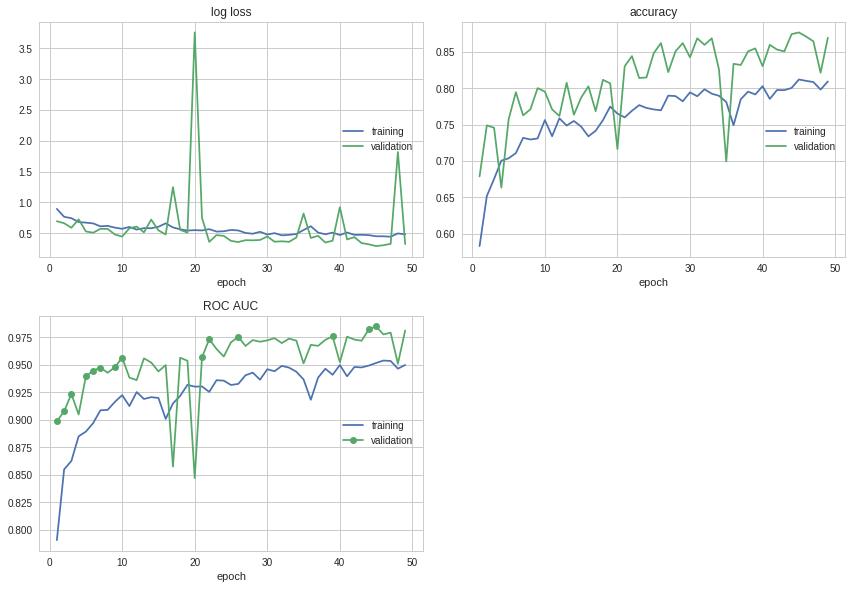


Epoch 50/100 - KFold 5/5


log loss:
training   (min:    0.445, max:    0.895, cur:    0.482)
validation (min:    0.292, max:    3.756, cur:    0.325)

accuracy:
training   (min:    0.583, max:    0.812, cur:    0.809)
validation (min:    0.663, max:    0.876, cur:    0.869)

ROC AUC:
training   (min:    0.790, max:    0.954, cur:    0.950)
validation (min:    0.847, max:    0.985, cur:    0.981)


Training interrupted
End training DenseNet model
Training complete in 262m 41s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1.5000, 1.0000, 1.0000], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 1e-05
)
  362 parameters to train:
    features.denseblock3.denselayer1.norm1.weight
    features.denseblock3.denselayer1.norm1.bias
    features.denseblock3.denselayer1.conv1.weight
    features.denseblock3.denselayer1.norm2.weight
    features.denseblock3.denselayer1.norm2.bias
    ...
    features.denseblock4.denselayer24.norm2.weight
    features.denseblock4.denselayer24.norm2.bias
    features.denseblock4.denselayer24.conv2.weight
    classifier.weight
    classifier.bias
  Train tranforms: Compose(
    RandomResized

In [0]:
model, image_size = initialize_model('densenet', len(classes), use_pretrained=True)

# Freeze denseblock1 and denseblock2
# Train  denseblock3 and denseblock4
set_parameter_requires_grad(itertools.chain(model.features.denseblock3.parameters(), 
                                            model.features.denseblock4.parameters()), feature_extract=False)

optimizer = optim.Adam(get_params_to_update(model).values(), lr=0.001, weight_decay=1e-6)

dr_densenet_model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

Editor's note: while validation metrics are excellent after 100 epochs, test metrics falls! It overfits to the training/validation set. So I did not keep the very last models. But some model in the middle of training.

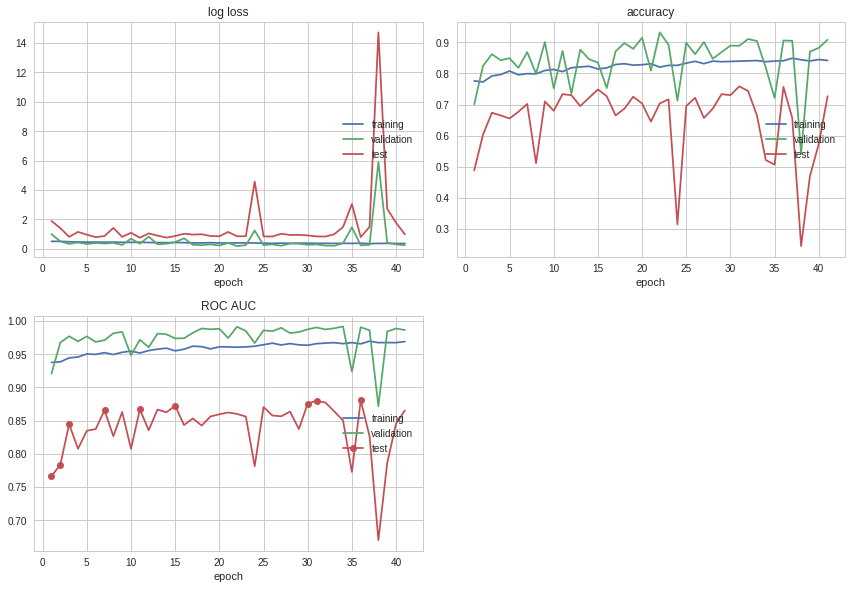


Epoch 42/100 - KFold 2/5


log loss:
training             (min:    0.359, max:    0.513, cur:    0.367)
validation           (min:    0.191, max:    5.886, cur:    0.249)
test                 (min:    0.763, max:   14.693, cur:    0.988)

accuracy:
training             (min:    0.773, max:    0.849, cur:    0.842)
validation           (min:    0.541, max:    0.932, cur:    0.908)
test                 (min:    0.245, max:    0.758, cur:    0.727)

ROC AUC:
training             (min:    0.937, max:    0.969, cur:    0.969)
validation           (min:    0.872, max:    0.992, cur:    0.986)
test                 (min:    0.670, max:    0.880, cur:    0.865)


Training interrupted
End training ResNet model
Training complete in 231m 15s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1.5000, 1.0000, 1.0000], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  194 parameters to train:
    layer3.18.conv1.weight
    layer3.18.bn1.weight
    layer3.18.bn1.bias
    layer3.18.conv2.weight
    layer3.18.bn2.weight
    ...
    layer4.2.conv3.weight
    layer4.2.bn3.weight
    layer4.2.bn3.bias
    fc.weight
    fc.bias
  Train tranforms: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.7, 1), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomApply(
    p=0.25
)
    RandomApply(
    p=0.25
)
    RandomAffine(degrees=(-30, 30), translate=(0.2, 0.2), scal

In [0]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/ResNet_1_0.8552.pt'))
resnet_model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

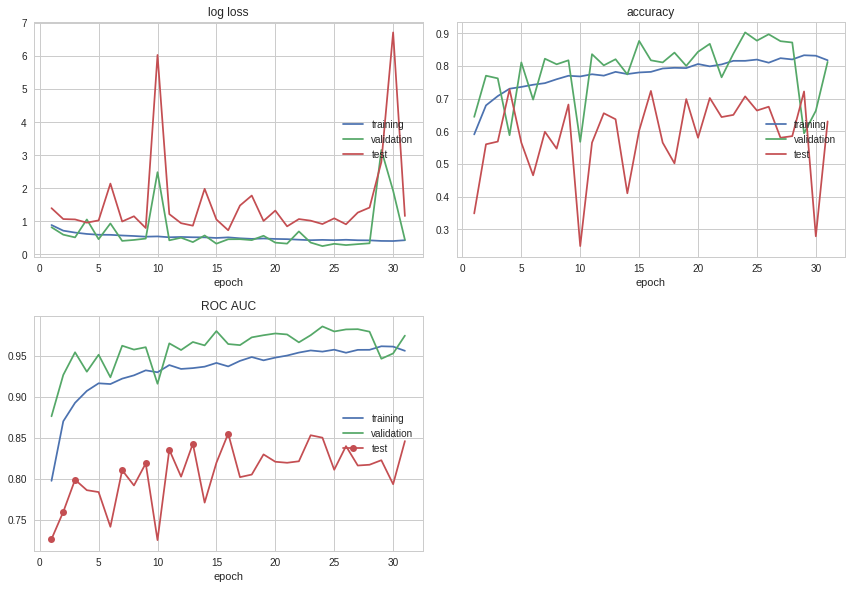


Epoch 32/100 - KFold 2/5


log loss:
training             (min:    0.403, max:    0.887, cur:    0.428)
validation           (min:    0.250, max:    3.156, cur:    0.442)
test                 (min:    0.729, max:    6.711, cur:    1.160)

accuracy:
training             (min:    0.590, max:    0.833, cur:    0.817)
validation           (min:    0.567, max:    0.902, cur:    0.812)
test                 (min:    0.248, max:    0.728, cur:    0.630)

ROC AUC:
training             (min:    0.798, max:    0.962, cur:    0.956)
validation           (min:    0.876, max:    0.986, cur:    0.975)
test                 (min:    0.725, max:    0.855, cur:    0.846)


In [0]:
resnet_model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

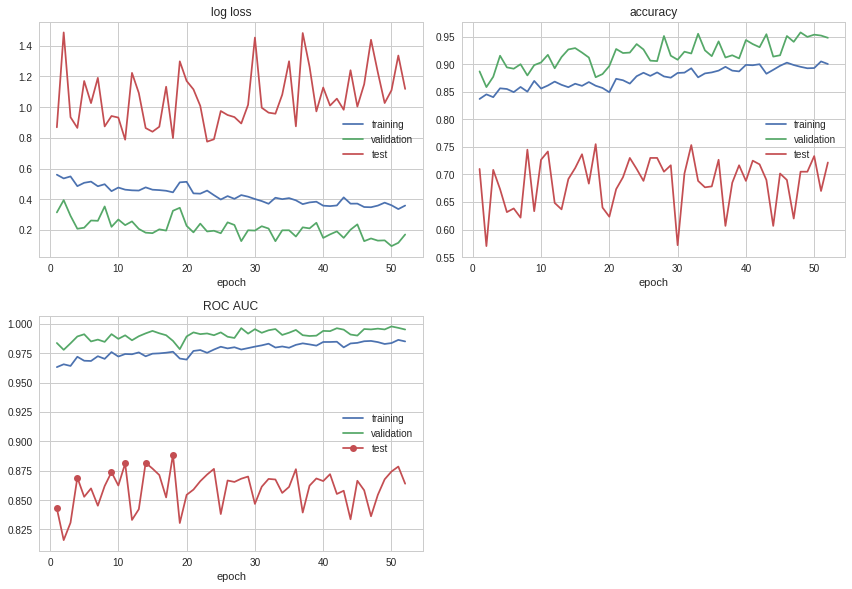


Epoch 53/100 - KFold 3/5


log loss:
training             (min:    0.335, max:    0.560, cur:    0.358)
validation           (min:    0.094, max:    0.394, cur:    0.170)
test                 (min:    0.775, max:    1.487, cur:    1.119)

accuracy:
training             (min:    0.837, max:    0.905, cur:    0.900)
validation           (min:    0.859, max:    0.958, cur:    0.948)
test                 (min:    0.570, max:    0.755, cur:    0.722)

ROC AUC:
training             (min:    0.963, max:    0.986, cur:    0.985)
validation           (min:    0.978, max:    0.998, cur:    0.995)
test                 (min:    0.816, max:    0.889, cur:    0.864)


Training interrupted
End training Inception3 model
Training complete in 341m 32s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1.5000, 1.0000, 1.0000], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  271 parameters to train:
    Mixed_5b.branch1x1.conv.weight
    Mixed_5b.branch1x1.bn.weight
    Mixed_5b.branch1x1.bn.bias
    Mixed_5b.branch5x5_1.conv.weight
    Mixed_5b.branch5x5_1.bn.weight
    ...
    Mixed_7c.branch_pool.conv.weight
    Mixed_7c.branch_pool.bn.weight
    Mixed_7c.branch_pool.bn.bias
    fc.weight
    fc.bias
  Train tranforms: Compose(
    RandomResizedCrop(size=(299, 299), scale=(0.75, 1), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHair probability=0.25
    Rand

In [0]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/Inception3_2_0.8642.pt'))
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

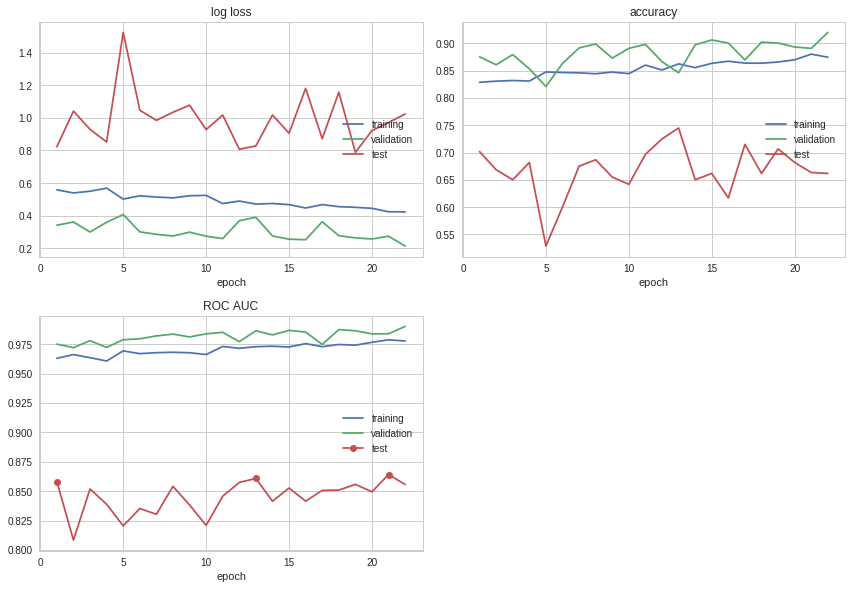

In [0]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/Inception3_2_0.8642.pt'))
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

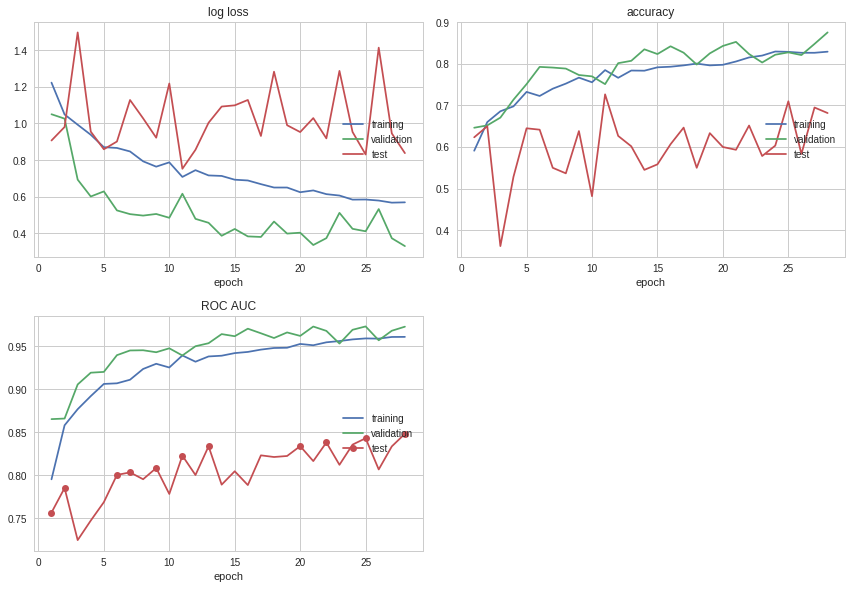


Epoch 29/100 - KFold 4/5


log loss:
training             (min:    0.568, max:    1.223, cur:    0.570)
validation           (min:    0.331, max:    1.050, cur:    0.331)
test                 (min:    0.753, max:    1.497, cur:    0.838)

accuracy:
training             (min:    0.591, max:    0.830, cur:    0.829)
validation           (min:    0.646, max:    0.876, cur:    0.876)
test                 (min:    0.362, max:    0.727, cur:    0.682)

ROC AUC:
training             (min:    0.795, max:    0.961, cur:    0.961)
validation           (min:    0.865, max:    0.973, cur:    0.973)
test                 (min:    0.724, max:    0.848, cur:    0.848)


Training interrupted
End training Inception3 model
Training complete in 156m 15s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1.5000, 1.0000, 1.0000], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  271 parameters to train:
    Mixed_5b.branch1x1.conv.weight
    Mixed_5b.branch1x1.bn.weight
    Mixed_5b.branch1x1.bn.bias
    Mixed_5b.branch5x5_1.conv.weight
    Mixed_5b.branch5x5_1.bn.weight
    ...
    Mixed_7c.branch_pool.conv.weight
    Mixed_7c.branch_pool.bn.weight
    Mixed_7c.branch_pool.bn.bias
    fc.weight
    fc.bias
  Train tranforms: Compose(
    RandomResizedCrop(size=(299, 299), scale=(0.75, 1), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomAffine(degrees=(-30, 30), tran

In [0]:
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

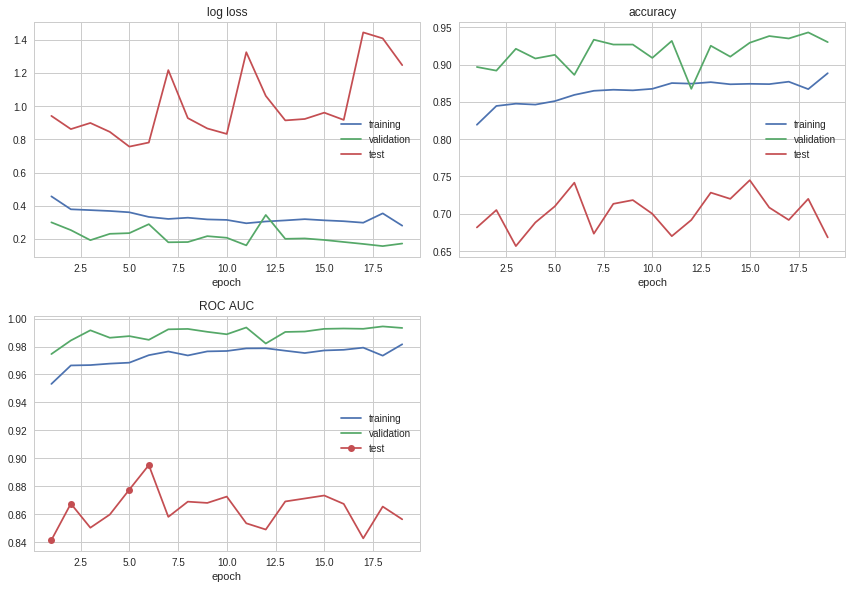


Epoch 20/100 - KFold 5/5


log loss:
training             (min:    0.280, max:    0.456, cur:    0.280)
validation           (min:    0.157, max:    0.344, cur:    0.172)
test                 (min:    0.756, max:    1.444, cur:    1.247)

accuracy:
training             (min:    0.819, max:    0.888, cur:    0.888)
validation           (min:    0.867, max:    0.943, cur:    0.930)
test                 (min:    0.657, max:    0.745, cur:    0.668)

ROC AUC:
training             (min:    0.953, max:    0.982, cur:    0.982)
validation           (min:    0.975, max:    0.994, cur:    0.993)
test                 (min:    0.841, max:    0.895, cur:    0.856)


Training interrupted
End training DenseNet model
Training complete in 104m 53s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1.5000, 1.0000, 1.0000], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  362 parameters to train:
    features.denseblock3.denselayer1.norm1.weight
    features.denseblock3.denselayer1.norm1.bias
    features.denseblock3.denselayer1.conv1.weight
    features.denseblock3.denselayer1.norm2.weight
    features.denseblock3.denselayer1.norm2.bias
    ...
    features.denseblock4.denselayer24.norm2.weight
    features.denseblock4.denselayer24.norm2.bias
    features.denseblock4.denselayer24.conv2.weight
    classifier.weight
    classifier.bias
  Train tranforms: Compose(
    RandomResized

In [0]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/DenseNet_7_0.8915.pt'))
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

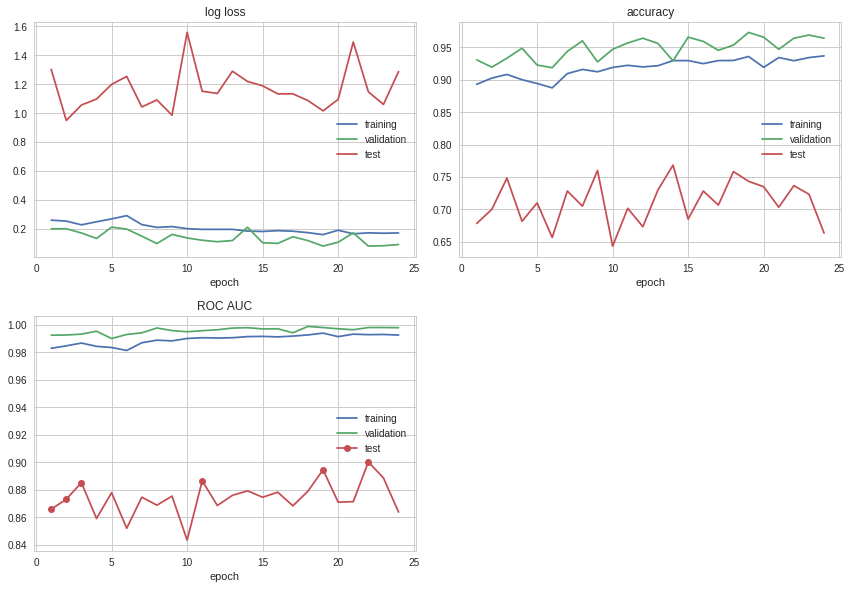


Epoch 25/100 - KFold 5/5


log loss:
training             (min:    0.159, max:    0.290, cur:    0.170)
validation           (min:    0.080, max:    0.211, cur:    0.090)
test                 (min:    0.949, max:    1.559, cur:    1.288)

accuracy:
training             (min:    0.888, max:    0.937, cur:    0.937)
validation           (min:    0.919, max:    0.973, cur:    0.964)
test                 (min:    0.643, max:    0.768, cur:    0.663)

ROC AUC:
training             (min:    0.981, max:    0.994, cur:    0.993)
validation           (min:    0.990, max:    0.999, cur:    0.998)
test                 (min:    0.843, max:    0.900, cur:    0.864)


Training interrupted
End training DenseNet model
Training complete in 120m 23s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1.5000, 1.0000, 1.0000], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  362 parameters to train:
    features.denseblock3.denselayer1.norm1.weight
    features.denseblock3.denselayer1.norm1.bias
    features.denseblock3.denselayer1.conv1.weight
    features.denseblock3.denselayer1.norm2.weight
    features.denseblock3.denselayer1.norm2.bias
    ...
    features.denseblock4.denselayer24.norm2.weight
    features.denseblock4.denselayer24.norm2.bias
    features.denseblock4.denselayer24.conv2.weight
    classifier.weight
    classifier.bias
  Train tranforms: Compose(
    RandomResized

In [0]:
##########################
VERY BEST OF => REACH 0.900 => and then 0.908 with 3 test models 0.71, 0.73, 0.84
##########################
model.load_state_dict(torch.load('/content/gdrive/My Drive/DenseNet_7_0.8915.pt'))
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

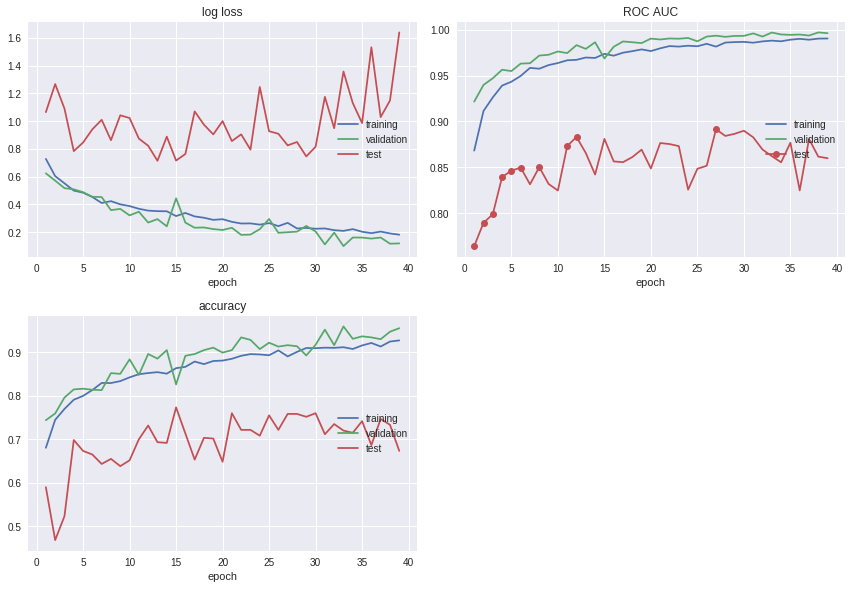


Epoch 40/100 - KFold 5/5


log loss:
training             (min:    0.182, max:    0.728, cur:    0.182)
validation           (min:    0.100, max:    0.624, cur:    0.119)
test                 (min:    0.714, max:    1.639, cur:    1.639)

ROC AUC:
training             (min:    0.868, max:    0.991, cur:    0.991)
validation           (min:    0.922, max:    0.997, cur:    0.996)
test                 (min:    0.764, max:    0.891, cur:    0.860)

accuracy:
training             (min:    0.680, max:    0.927, cur:    0.927)
validation           (min:    0.744, max:    0.959, cur:    0.955)
test                 (min:    0.468, max:    0.773, cur:    0.673)


In [0]:
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

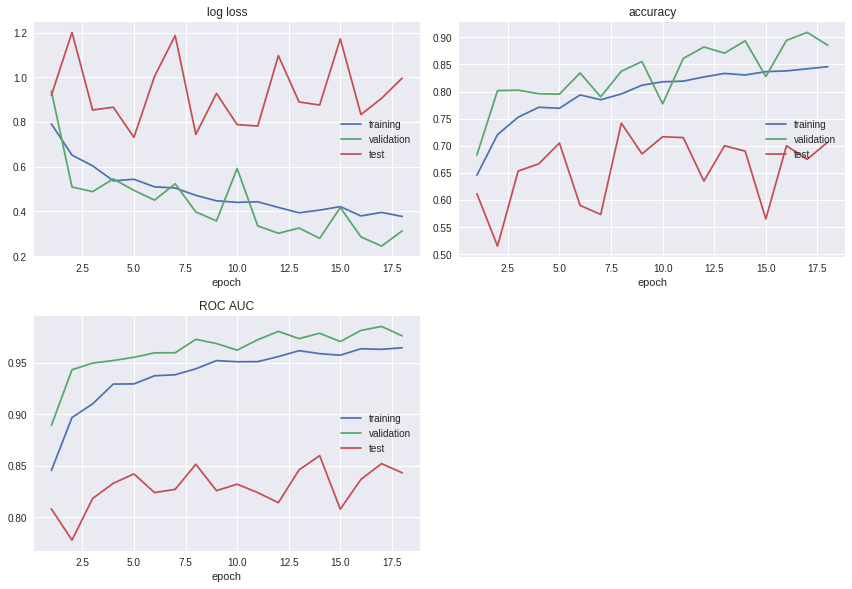


Epoch 19/100 - KFold 4/5


log loss:
training             (min:    0.377, max:    0.791, cur:    0.377)
validation           (min:    0.245, max:    0.938, cur:    0.313)
test                 (min:    0.731, max:    1.201, cur:    0.996)

accuracy:
training             (min:    0.646, max:    0.846, cur:    0.846)
validation           (min:    0.683, max:    0.909, cur:    0.885)
test                 (min:    0.515, max:    0.742, cur:    0.707)

ROC AUC:
training             (min:    0.845, max:    0.965, cur:    0.965)
validation           (min:    0.889, max:    0.986, cur:    0.976)
test                 (min:    0.778, max:    0.860, cur:    0.843)


Training interrupted
End training DenseNet model
Training complete in 98m 50s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1., 1., 1.], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  362 parameters to train:
    features.denseblock3.denselayer1.norm1.weight
    features.denseblock3.denselayer1.norm1.bias
    features.denseblock3.denselayer1.conv1.weight
    features.denseblock3.denselayer1.norm2.weight
    features.denseblock3.denselayer1.norm2.bias
    ...
    features.denseblock4.denselayer24.norm2.weight
    features.denseblock4.denselayer24.norm2.bias
    features.denseblock4.denselayer24.conv2.weight
    classifier.weight
    classifier.bias
  Train tranforms: Compose(
    RandomResizedCrop(size=(22

In [0]:
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

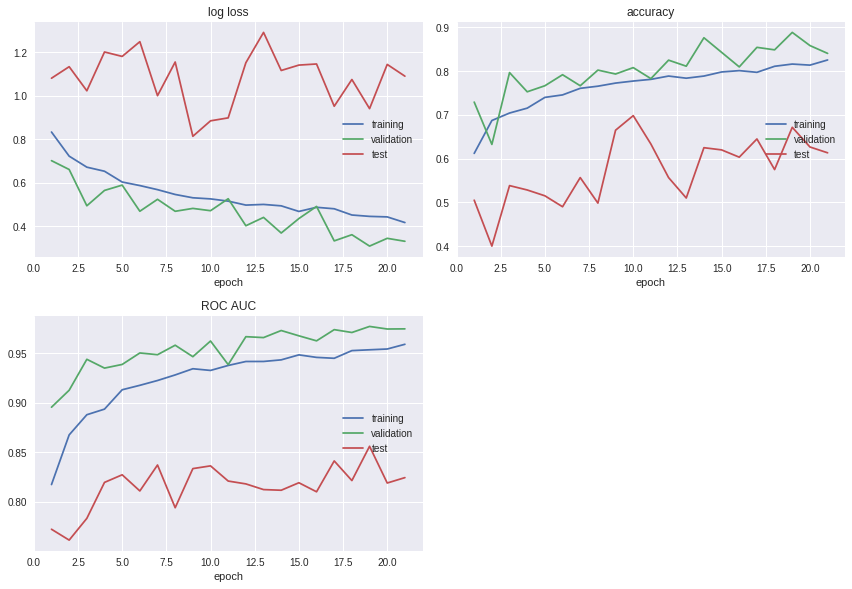


Epoch 22/100 - KFold 2/5


log loss:
training             (min:    0.417, max:    0.834, cur:    0.417)
validation           (min:    0.309, max:    0.702, cur:    0.331)
test                 (min:    0.814, max:    1.292, cur:    1.091)

accuracy:
training             (min:    0.612, max:    0.826, cur:    0.826)
validation           (min:    0.633, max:    0.889, cur:    0.841)
test                 (min:    0.400, max:    0.698, cur:    0.613)

ROC AUC:
training             (min:    0.818, max:    0.959, cur:    0.959)
validation           (min:    0.896, max:    0.977, cur:    0.975)
test                 (min:    0.762, max:    0.856, cur:    0.825)


Training interrupted
End training DenseNet model
Training complete in 120m 59s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([1.5000, 1.0000, 1.0000], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  362 parameters to train:
    features.denseblock3.denselayer1.norm1.weight
    features.denseblock3.denselayer1.norm1.bias
    features.denseblock3.denselayer1.conv1.weight
    features.denseblock3.denselayer1.norm2.weight
    features.denseblock3.denselayer1.norm2.bias
    ...
    features.denseblock4.denselayer24.norm2.weight
    features.denseblock4.denselayer24.norm2.bias
    features.denseblock4.denselayer24.conv2.weight
    classifier.weight
    classifier.bias
  Train tranforms: Compose(
    RandomResized

In [0]:
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

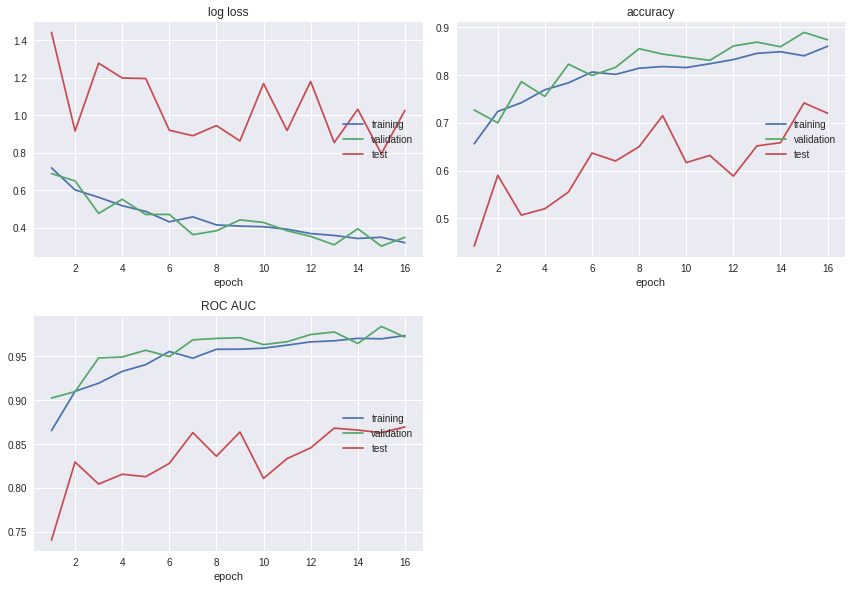


Epoch 17/100 - KFold 2/5


log loss:
training             (min:    0.321, max:    0.720, cur:    0.321)
validation           (min:    0.303, max:    0.689, cur:    0.350)
test                 (min:    0.795, max:    1.441, cur:    1.026)

accuracy:
training             (min:    0.656, max:    0.860, cur:    0.860)
validation           (min:    0.700, max:    0.889, cur:    0.874)
test                 (min:    0.442, max:    0.742, cur:    0.720)

ROC AUC:
training             (min:    0.865, max:    0.974, cur:    0.974)
validation           (min:    0.903, max:    0.984, cur:    0.972)
test                 (min:    0.740, max:    0.870, cur:    0.870)


Training interrupted
End training DenseNet model
Training complete in 89m 59s
  Class distribution (4265): 1887 melanoma, 2050 nevus, 328 seborrheic_keratosis
  Oversampling: True
  Cross validation: 5
  Leaving 0 samples for untrained validation
  Loss function: CrossEntropyLoss() - Weights: tensor([2., 1., 1.], device='cuda:0')
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)
  362 parameters to train:
    features.denseblock3.denselayer1.norm1.weight
    features.denseblock3.denselayer1.norm1.bias
    features.denseblock3.denselayer1.conv1.weight
    features.denseblock3.denselayer1.norm2.weight
    features.denseblock3.denselayer1.norm2.bias
    ...
    features.denseblock4.denselayer24.norm2.weight
    features.denseblock4.denselayer24.norm2.bias
    features.denseblock4.denselayer24.conv2.weight
    classifier.weight
    classifier.bias
  Train tranforms: Compose(
    RandomResizedCrop(size=(22

In [0]:
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

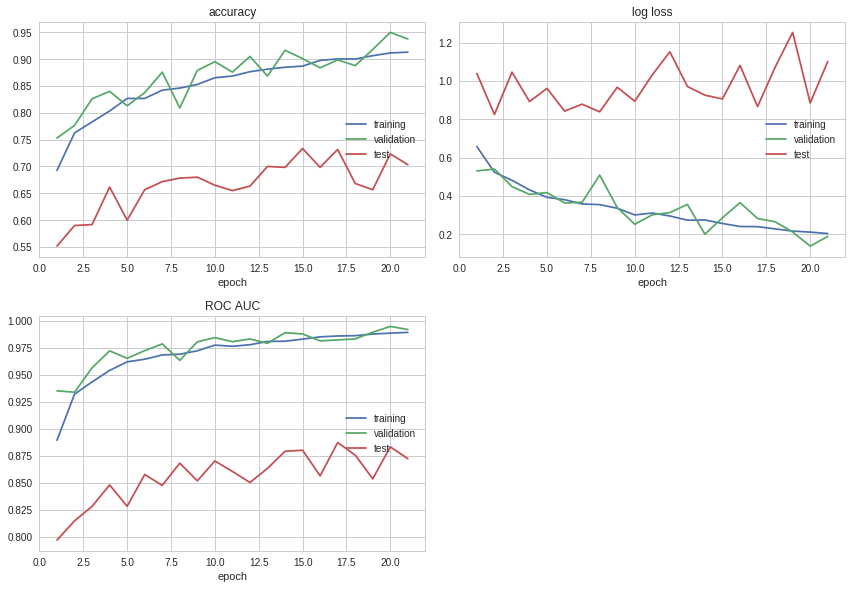


Epoch 22/100 - KFold 2/5


accuracy:
training             (min:    0.693, max:    0.913, cur:    0.913)
validation           (min:    0.753, max:    0.950, cur:    0.937)
test                 (min:    0.552, max:    0.733, cur:    0.703)

log loss:
training             (min:    0.204, max:    0.658, cur:    0.204)
validation           (min:    0.138, max:    0.540, cur:    0.189)
test                 (min:    0.825, max:    1.254, cur:    1.102)

ROC AUC:
training             (min:    0.889, max:    0.989, cur:    0.989)
validation           (min:    0.934, max:    0.995, cur:    0.992)
test                 (min:    0.797, max:    0.887, cur:    0.872)


Items processed: {'melanoma': 1640, 'nevus': 1640, 'seborrheic_keratosis': 1640}
train_loss=0.196, train_acc=0.918, melan_acc=0.927, nevus_acc=0.852, sebor_acc=0.975
Cat 1 ROC AUC: 0.981 Cat 2 ROC AUC: 0.998 Cat 3 ROC AUC: 0.990


Items processed: {'melanoma': 410, 'nevus': 410, 'seborrheic_keratosis': 410}
valid_loss=0.215, valid_acc=0.904, melan_acc=0.920, nevus_acc=0.859, sebor_acc=0.934
Cat 1 ROC AUC: 0.978 Cat 2 ROC AUC: 1.000 Cat 3 ROC AUC: 0.989


Items processed: {'melanoma': 117, 'nevus': 393, 'seborrheic_keratosis': 90}
test_loss=1.087, test_acc=0.705, melan_acc=0.778, nevus_acc=0.679, sebor_acc=0.722
Cat 1 ROC AUC: 0.834 Cat 2 ROC AUC: 0.924 Cat 3 ROC AUC: 0.879


In [0]:
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

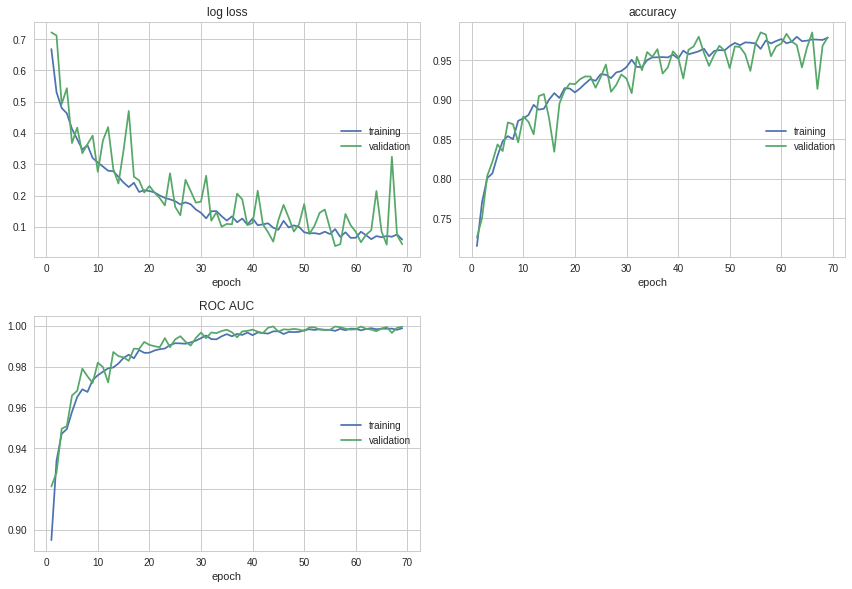

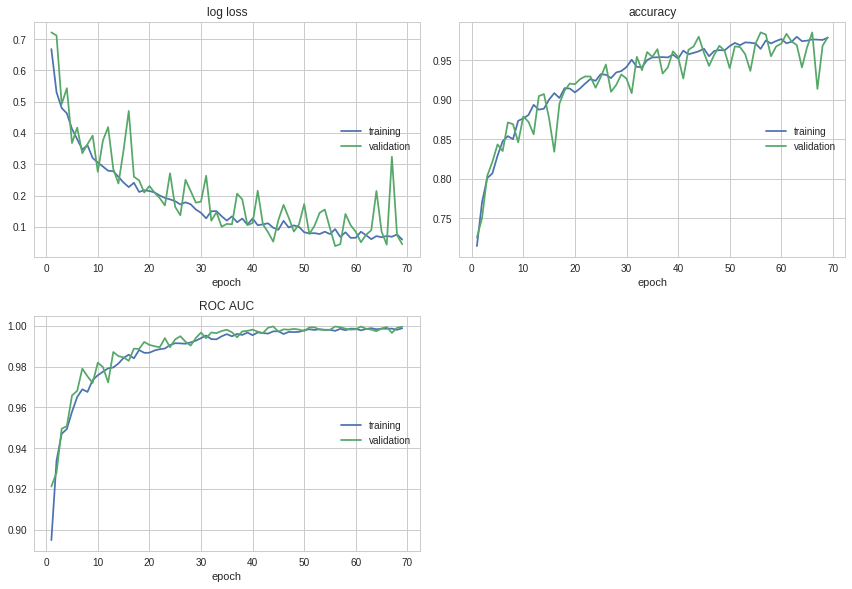



Epoch 70/100 - KFold 5/5
Epoch 70/100 - KFold 5/5


log loss:
training   (min:    0.059, max:    0.668, cur:    0.059)
validation (min:    0.038, max:    0.721, cur:    0.044)

accuracy:
training   (min:    0.715, max:    0.979, cur:    0.978)
validation (min:    0.726, max:    0.985, cur:    0.979)

ROC AUC:
training   (min:    0.895, max:    0.999, cur:    0.999)
validation (min:    0.921, max:    1.000, cur:    1.000)
log loss:
training   (min:    0.059, max:    0.668, cur:    0.059)
validation (min:    0.038, max:    0.721, cur:    0.044)

accuracy:
training   (min:    0.715, max:    0.979, cur:    0.978)
validation (min:    0.726, max:    0.985, cur:    0.979)

ROC AUC:
training   (min:    0.895, max:    0.999, cur:    0.999)
validation (min:    0.921, max:    1.000, cur:    1.000)


Items processed: {'melanoma': 1510, 'nevus': 1510, 'seborrheic_keratosis': 1510}
Items processed: {'melanoma': 1510, 'nevus': 1510, 'seborrheic_keratosis': 1510}
train_loss=0.066, train_acc=0.975, melan_acc=0.966, nevus_acc=0.962, sebor_acc=0.997
train_loss=0.066, train_acc=0.975, melan_acc=0.966, nevus_acc=0.962, sebor_acc=0.997
Cat 1 ROC AUC: 0.997 Cat 2 ROC AUC: 1.000 Cat 3 ROC AUC: 0.999
Cat 1 ROC AUC: 0.997 Cat 2 ROC AUC: 1.000 Cat 3 ROC AUC: 0.999


Buffered data was truncated after reaching the output size limit.Buffered data was truncated after reaching the output size limit.

In [0]:
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, num_epochs=100)

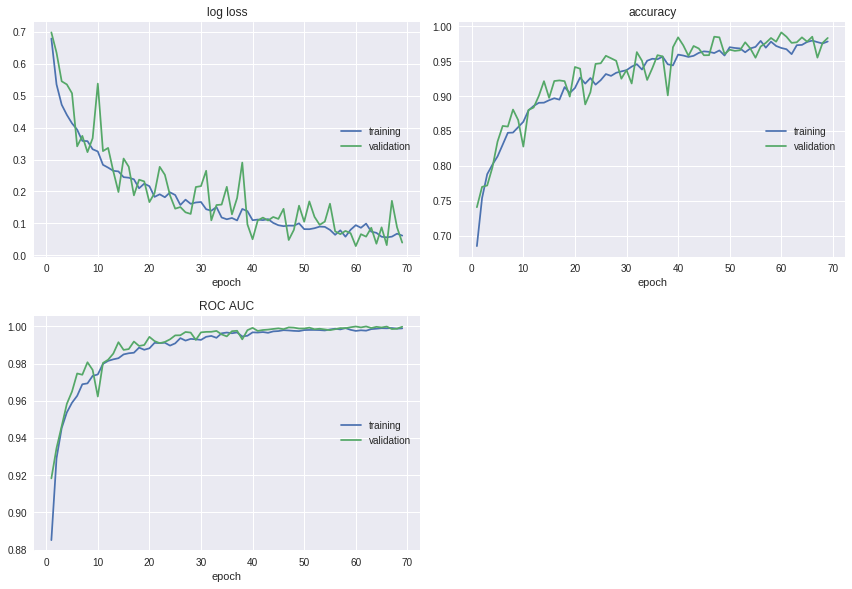


Epoch 70/100 - KFold 5/5


log loss:
training   (min:    0.057, max:    0.679, cur:    0.062)
validation (min:    0.029, max:    0.698, cur:    0.040)

accuracy:
training   (min:    0.685, max:    0.979, cur:    0.978)
validation (min:    0.741, max:    0.991, cur:    0.983)

ROC AUC:
training   (min:    0.885, max:    0.999, cur:    0.999)
validation (min:    0.918, max:    1.000, cur:    1.000)


Items processed: {'melanoma': 1510, 'nevus': 1510, 'seborrheic_keratosis': 1510}
train_loss=0.052, train_acc=0.981, melan_acc=0.979, nevus_acc=0.966, sebor_acc=0.997
Cat 1 ROC AUC: 0.998 Cat 2 ROC AUC: 1.000 Cat 3 ROC AUC: 0.999


Items processed: {'melanoma': 377, 'nevus': 377, 'seborrheic_keratosis': 377}
valid_loss=0.059, valid_acc=0.984, melan_acc=0.958, nevus_acc=0.995, sebor_acc=1.000
Cat 1 ROC AUC: 0.999 Cat 2 ROC AUC: 1.000 Cat 3 ROC AUC: 1.000


Buffered data was truncated after reaching the output size limit.

In [0]:
model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, num_epochs=100)

# Evaluate the Model

Inspired by the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a), the algorithm is ranked according to three separate categories:
- Category 1: ROC AUC for Melanoma Classification
- Category 2: ROC AUC for Melanocytic Classification
- Category 3: Mean ROC AUC

The test_model function below calculates the test Mean ROC AUC of the model on the test set.  
It also returns a data frame with the probabilities of detection of melanoma and seborrheic keratoses in the given images.

In [0]:
def get_file_names(dirs):
  # it returns class_id for each sample in the provided folders [0 0 0 1 1 2]
  
  file_names = []
  for d in dirs:
      file_names = np.append(file_names, [fn.replace(d,'') for fn in sorted(glob.glob(os.path.join(d, '*', '*.jpg')))])
  return file_names

def test_model(data_loader, dirs, model, criterion):
                         
    _, best_auc, _, running_corrects, items_processed, data = epoch_run('test', data_loader, model, criterion)            

    file_names = get_file_names(dirs)
    
    return pd.DataFrame(index=file_names[0:sum(items_processed.values())], data=data, columns=classes), running_corrects, items_processed, best_auc

In [0]:
def get_test_loader(image_size=224, original_image=False, resize=0.75):
  
  test_transforms = transforms.Compose([
                                        transforms.Resize(int(image_size/resize)),
                                        transforms.CenterCrop(image_size),
                                        transforms.ToTensor(),
                                        normalize])

  test_image_folder = datasets.ImageFolder(data_dir['test'] + ('' if original_image else '_resized'), transform=test_transforms)
  
  return torch.utils.data.DataLoader(test_image_folder, batch_size=batch_size['test'], num_workers=num_workers, shuffle=False)

In [0]:
import os
import errno

def load_model(state_dict_fn):
  
  model_name = state_dict_fn.split(os.path.sep)[-1].split('_')[0].lower()
  model, image_size = initialize_model(model_name, len(classes))
  my_drive = '/content/gdrive/My Drive/'
  
  if os.path.exists(state_dict_fn):    
    model.load_state_dict(torch.load(state_dict_fn))
  elif os.path.exists(my_drive + state_dict_fn):
    model.load_state_dict(torch.load(my_drive + state_dict_fn))
  else:
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), state_dict_fn)
  
  return model

In [0]:
def get_ground_truth():
    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])
    return y_true

In [0]:
dr_densenet_model = load_model('DenseNet_1_0.9003.pt')

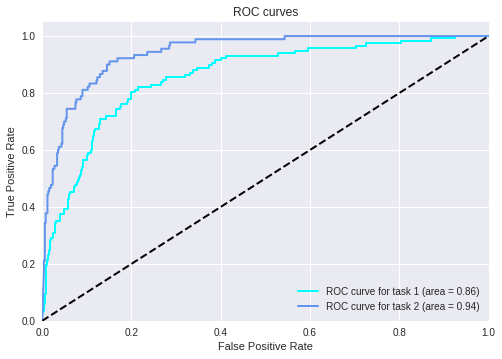

Category 1 Score: 0.858
Category 2 Score: 0.943
Category 3 Score: 0.900


In [0]:
predictions, _, _, _ = test_model(get_test_loader(resize=0.75), phase_data_dirs['test'], dr_densenet_model, criterion)

subset_predictions = predictions.as_matrix(columns=[classes[0], classes[2]])

y_true = get_ground_truth()

_ = get_roc_auc(y_true, subset_predictions, plot=True)

0.900 ! Well done!!!  

__Dr. DenseNet__ is an excellent Doctor, with excellent results!  If he had participated in the [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a), he __would have reached the TOP 4!__

But it's still a human and sometimes he makes mistakes. As I am a rather anxious person, I would prefer to ask for a second medical opinion... (My fifth mistake was to be too confident in one single doctor 😉)



# Go Further

## Second Medical Opinion

So let's seek for a second medical opinion from __Dr. [Inception v3](https://arxiv.org/abs/1512.00567)__:

In [0]:
model, image_size = initialize_model('inception', len(classes), use_pretrained=True)

# Freeze Mixed 1 -> 4
# Train  Mixed 5 -> 7
set_parameter_requires_grad(itertools.chain(
                                            model.Mixed_5b.parameters(),
                                            model.Mixed_5c.parameters(),
                                            model.Mixed_5d.parameters(),
                                            model.Mixed_6a.parameters(),
                                            model.Mixed_6b.parameters(),
                                            model.Mixed_6c.parameters(),
                                            model.Mixed_6d.parameters(),
                                            model.Mixed_6e.parameters(),
                                            model.Mixed_7a.parameters(),
                                            model.Mixed_7b.parameters(),
                                            model.Mixed_7c.parameters()), feature_extract=False)

optimizer = optim.Adam(get_params_to_update(model).values(), lr=0.001, weight_decay=1e-6)

dr_inception_model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

In [0]:
dr_inception_model = load_model('Inception3_2_0.8886.pt')

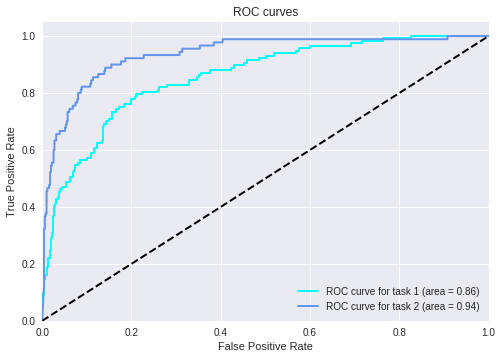

Category 1 Score: 0.857
Category 2 Score: 0.936
Category 3 Score: 0.897


In [0]:
predictions, _, _, _ = test_model(get_test_loader(), phase_data_dirs['test'], dr_inception_model, criterion)
subset_predictions = predictions.as_matrix(columns=[classes[0], classes[2]])
_ = get_roc_auc(y_true, subset_predictions, plot=True)

## Third Medical Opinion

I now have two medical opinions! Great! But __Dr. DenseNet and Dr. Inception sometimes gives me opposite opinion!__  
So let's look for a third medical opinion that will be able to decide: __Dr. [Resnet](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035) arrives on stage!__

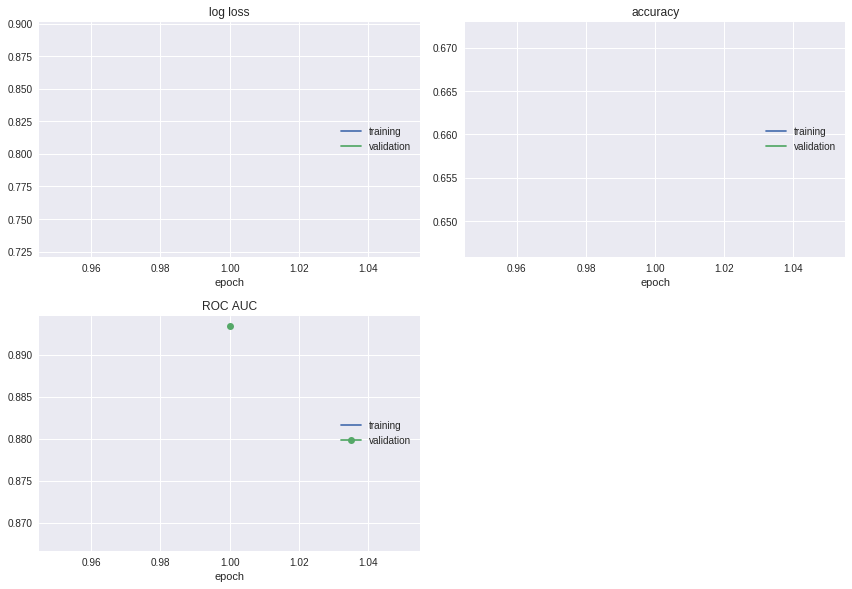


Epoch 2/100 - KFold 2/5


log loss:
training   (min:    0.729, max:    0.729, cur:    0.729)
validation (min:    0.893, max:    0.893, cur:    0.893)

accuracy:
training   (min:    0.672, max:    0.672, cur:    0.672)
validation (min:    0.647, max:    0.647, cur:    0.647)

ROC AUC:
training   (min:    0.868, max:    0.868, cur:    0.868)
validation (min:    0.893, max:    0.893, cur:    0.893)


In [0]:
model, image_size = initialize_model('resnet', len(classes), use_pretrained=True)

# Freeze layer1, layer 2 and layer3 Bottleneck 0 -> 17
# Train  layer3 Bottleneck 18 -> 35 and layer4
set_parameter_requires_grad(itertools.chain.from_iterable([model.layer3[i].parameters() for i in range(18,36)] + 
                                            [model.layer4.parameters()]), feature_extract=False)

optimizer = optim.Adam(get_params_to_update(model).values(), lr=0.001, weight_decay=1e-6)

dr_resnet_model = train_model(model, loaders, criterion, optimizer, phase_data_dirs_resized, over_sampling=True, cv=5, test_split=None, num_epochs=100)

In [0]:
dr_resnet_model = load_model('ResNet_1_0.8803.pt')

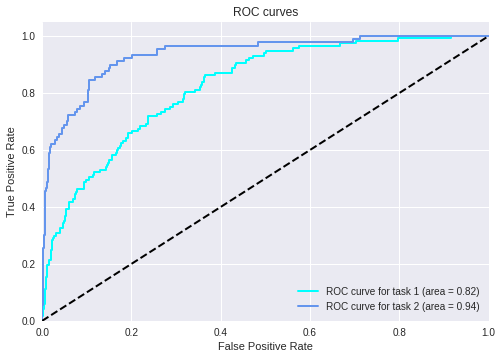

Category 1 Score: 0.824
Category 2 Score: 0.936
Category 3 Score: 0.880


In [0]:
predictions, _, _, _ = test_model(get_test_loader(), phase_data_dirs['test'], dr_resnet_model, criterion)
subset_predictions = predictions.as_matrix(columns=[classes[0], classes[2]])
_ = get_roc_auc(y_true, subset_predictions, plot=True)

## Committee of Doctors

I'm lucky enough to bring together my three doctors in a committee! Alone, they all fit in the top 7! What a dream team!

They share their results, debate, and __Dr. Inception comes to suggest looking at the dermatoscopic images from different perspectives__.  

He suggest scaling to the following values:

In [0]:
scales = [0.7, 0.75, 0.8, 0.85]

In [0]:
def test_model_with(dirs, resizes, model, criterion, original_images):
  
  all_predictions = {}
  
  for resize in resizes:
    print(f'\nTesting {model.__class__.__name__} with resize /{resize}')
    image_size = get_image_size(model.__class__.__name__.lower())
    predictions, corrects, items_processed, best_auc = test_model(get_test_loader(resize=resize), dirs, model, criterion)
    all_predictions[resize] = (predictions, corrects, items_processed, best_auc)
    
  return all_predictions

In [0]:
def get_row(test_result, scale, model):
  
  corrects = [val.cpu().numpy() for val in test_result[1].values()]
  items_processed = test_result[2].values()
  
  return [f'Dr. {model.__class__.__name__}', 
          scale, 
          np.round(sum(corrects)/sum(items_processed), 3), 
          np.round(test_result[3], 3)]
  

In [0]:
def append_row(summary, new_row, background=''):
  
  return summary.append({'Model': f'<b>{new_row[0]}</b>', 
                'Resize':f'{new_row[1]:.3f}', 
                'Accuracy': '<b{0}>{1:.3f}</b>'.format(background, new_row[2]),
                'Cat 3 ROC AUC': '<b{0}>{1:.3f}</b>'.format(background, new_row[3])
                         }, ignore_index=True)

In [0]:
def create_summary(predictions, trained_models, scales):
  
  data = [get_row(predictions[model_idx][scale], scale, trained_models[model_idx]) for scale in scales for model_idx in range(len(trained_models))]
  summary = pd.DataFrame(data=data, columns=['Model', 'Resize', 'Accuracy', 'Cat 3 ROC AUC'])
  summary = append_row(summary, ['Mean', summary['Resize'].mean(), summary['Accuracy'].mean(), summary['Cat 3 ROC AUC'].mean()])
  
  return summary

In [0]:
trained_models = [load_model(fn) for fn in ['Inception3_2_0.8886.pt', 'ResNet_1_0.8803.pt', 'DenseNet_1_0.9003.pt']]

In [0]:
#trained_models = [dr_inception_model, dr_resnet_model, dr_densenet_model]

predictions = {i:test_model_with(phase_data_dirs['test'], scales, trained_models[i], criterion, False) for i in range(len(trained_models))}


Testing Inception3 with resize /0.7



Testing Inception3 with resize /0.75



Testing Inception3 with resize /0.8



Testing Inception3 with resize /0.85



Testing ResNet with resize /0.7



Testing ResNet with resize /0.75



Testing ResNet with resize /0.8



Testing ResNet with resize /0.85



Testing DenseNet with resize /0.7



Testing DenseNet with resize /0.75



Testing DenseNet with resize /0.8



Testing DenseNet with resize /0.85


Here are their results at different perspectives:

In [0]:
from IPython.display import HTML

summary = create_summary(predictions, trained_models, scales)

HTML(summary.to_html(escape=False))

### Final scores

My sixth mistake was to try immediately to give a different weight to my prefered Dr. and yet different weights to the scales 😉. I even tried with [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html) to train another model on top on my 12\*3 features.   

Giving it a try is not a mistake! It's to start with a complex algorithm that makes the mistake.

There is a very __simple algorithm to try here__: let's give equal value to each perspective and extract for each image the __average of all probabilities__:


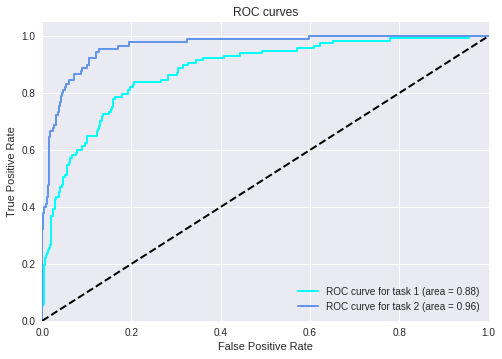

Category 1 Score: 0.878
Category 2 Score: 0.963
Category 3 Score: 0.921


In [0]:
predictions_by_model = {(model_idx, scale): predictions[model_idx][scale][0].as_matrix(columns=[classes[0], classes[1], classes[2]]) 
                        for scale in scales for model_idx in range(len(trained_models))}

mean_predictions = np.mean(list(predictions_by_model.values()), axis=0)
best_auc = get_roc_auc(y_true, mean_predictions[:, [0,2]], plot=True)

y = get_true_labels(phase_data_dirs['test'])

summary = append_row(summary, ['Committee of Doctors', 
                               np.NaN, 
                               sum(y == np.argmax(mean_predictions, axis=1))/mean_predictions.shape[0],
                               best_auc[2]], ' style="background-color: yellow"')

HTML(summary.to_html(escape=False))

Wow!  Great!  

__ROC AUC Mean score climbs to 0.921 and outperforms the first score of the initial challenge!__

Editor's note: before giving a try to multiple models, I had initially written in my conclusions: *"I only tried DenseNet with all parameters freezed! I'm pretty sure that __a combination of Resnet / Inception / VGG / DenseNet with some re-trained layers and a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier. html) would push the limits higher!__"*. And I was right! 😃😃😃

## XGBClassifier

I keep my trial with XGBClassifier here for reference.

In [0]:
def get_features(dirs, trained_models, criterion):
  
  dataset = ConcatDataset([datasets.ImageFolder(d + '_resized', transform=test_transforms) for d in dirs])
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size['train'], num_workers=num_workers)
  
  X = {}
  
  
  for model in trained_models:
    predictions, _, _ = test_model(data_loader, dirs, model, criterion)
    X[model.__class__.__name__] = predictions.as_matrix(columns=[classes[0], classes[1], classes[2]])
  
  return X

In [0]:
X_dict = get_features(phase_data_dirs['train'], trained_models, criterion)

X = np.empty((len(y),0))
for x in X_dict.values():
  X = np.append(X, x, axis=1)  

In [0]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

n_estimators = [150,200,250,300]
learning_rates = [0.04, 0.03, 0.02]
max_depth = [2, 3]
reg_lambda = [0.50]

param_grid = {'n_estimators': n_estimators, 'learning_rate': learning_rates, 'max_depth': max_depth, 'reg_lambda': reg_lambda}
  
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

xgb_clf = xgb.XGBClassifier()

gs = GridSearchCV(xgb_clf, param_grid, refit=True, cv=cv, scoring='accuracy', verbose=3, n_jobs=-1)
gs.fit(X, y)

print(f'Best Params: {gs.best_params_}')
print(f'Best Score:  {gs.best_score_}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.2min finished


Best Params: {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 250, 'reg_lambda': 0.5}
Best Score:  0.9749120750293083


In [0]:
X_test = np.append(np.append(predictions[0][0.75].as_matrix(columns=[classes[0], classes[1], classes[2]]), 
                   predictions[1][0.75].as_matrix(columns=[classes[0], classes[1], classes[2]]), axis=1),
                   predictions[2][0.75].as_matrix(columns=[classes[0], classes[1], classes[2]]), axis=1)


In [0]:
y_pred = gs.best_estimator_.predict_proba(X_test)
y_true = get_ground_truth()

plot_roc_auc(y_true, y_pred[:,[0,2]])

# Conclusions

I was able to achieve a __Mean ROC AUC score of 0.921__. It would have been a __TOP 1__ in the initial challenge (see scores below). It's very satisfying for what I wanted to achieve, especially since the __winner's score is 0.911__.  😃

But much more than this score, I learned a lot and sometimes the hard way, and took a lot of fun. 😅

![title](https://github.com/sebastienlange/dermatologist-ai/blob/master/images/cat_3.png?raw=1)

## Possible points of improvement
Here are possible points of improvement to reach better results:
- more or different __data augmentations__ techniques. Particularly, I integrated [imgaug](https://github.com/aleju/imgaug) lately, so there's __a lot to try with [imgaug](https://github.com/aleju/imgaug)__! Particularly add more noise in image (like improved fake hairs, patch and add fake ruler)
- use different source of images : all the images come from the same distribution
- try [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) with my three models
- give a chance to other transfer learning models: vgg16, Xception...
- fine tune learning rate and other optimizer hyper parameters to speed up gradient descent (Adam with lr 0.002 often worked with earlier versions of the model)
- __detect the area of interest for each image and zoom in on it__.
- give a try to other optimizers: AdaGrad, RMSProp, Adamax, Adadelta...
- try different batch_size to see how it impacts training (the final model reachs a GPU out of memory with a batch size of 64 [Google colab GPU])
- display images where the model fails to understand why it fails and maybe improve algorithm, data augmentation...